In [70]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
import matplotlib as mpl
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1

In [71]:
#Definition of the Key Parameters
dim=5 #Dimension  of the Hilbert a.k.a Random matrices of dimension dim x dim
A=1 #Probability distribution to take the RMT elements will be P~exp(-A x^2)
sigma=np.sqrt(A/2) #Standard deviation of the normal distribution
basis = np.identity(dim)
i=complex(0,1)
β=2 #Inverse temperature
tmax=100 #Maximum time we simulate. (Dimensionless) Typicaly the dip is found at t<=1
n_points_t=300 #Number of points in the time array
xlogscale=True #If True the time points will be uniformly distributed in logscale
if xlogscale:
    auxtmin=-2 #tmin=10**auxtmin
    auxtmax=np.log10(tmax)
    auxt=np.linspace(auxtmin, auxtmax, n_points_t)
    t_arr=10**(auxt)
else:
    t_arr=np.linspace(0, tmax, n_points_t)
Nav=300 #Number of random matrices to average over
hbar=1 #We use hbar=1

#Comment on dimensions of quantities: 
#Both the time and the inverse temperature are dimensionless. The underlying dimension of
#energy is given by A which gives a dimension to the elements of the Random Matrix

In [72]:
#Basic subroutines:
#Compute the dot product between a bra and a ket. Returns a complex number
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
#Compute the product between a jet and a bra. Returns an operator over the Hilbert space
@numba.jit(complex128[:,:](complex128[:], complex128[:]), nopython=True, fastmath=True, parallel=False)
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res

In [73]:
#Construct a Random Gaussian Orthogonal Matrix GOE (Time Reversal Symmetry is present)
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N) #Creates a random array normally distributed. Assumes sigma=1
    H=(auxH+auxH.T) #Summing any matrix and its transpose gives a symmetric matrix
    return H
#Construct a Random Gaussian Hermitian Matrix. GUE (No Time-Reversal Symmetry)
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128) #Define a N x N matrix
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma) #The elements in the diagonal are real.
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2) #Elements out of diagonal
            b=np.random.normal(0,sigma)/np.sqrt(2) #Take care with the sqrt(2) dividing
            #With this sqrt(2) the average modulus of the random numbers is the same as in 
            #the diagonal
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    return H
def unfoldSpectrum(E, order, n_bins):
    Emax=np.max(E)
    Emin=np.min(E)
    rhoE, bins=np.histogram(E, bins=np.linspace(Emin, Emax, n_bins+1), density='True')
    bins=bins[:-1]
    N_E=np.zeros(n_bins)
    dummyE=0
    dE=(bins[1]-bins[0])
    for k in range(n_bins):
        dummyE+=rhoE[k]*dE
        N_E[k]=dummyE
    fit=np.polyfit(bins, N_E, order)
    polyn=np.poly1d(fit)
    unf_E=dim*polyn(E)
    rhoE_unf, bins=np.histogram(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins+1), density='True')
    stdrho=np.std(rhoE_unf)
    ndiscard=np.sum(rhoE_unf>1/dim+2*stdrho) # # bins with ρ(E)>1/N+2σ. # bins to discard
    unf_E=unf_E[unf_E>bins[ndiscard]]
    unf_E=unf_E[unf_E<bins[-1-ndiscard]]
    return unf_E

The regularized OTOC is defined for any two operators $V$, $W$ as
$$F_\beta(t):=Z^{-1}(\beta)\mathrm{Tr}\{e^{-\beta H/4}Ve^{-\beta H/4}W(t)e^{-\beta H/4}V e^{-\beta H/4}W(t)\}$$
We will consider the operators
$$V=|m\rangle \langle n|, \qquad W(t)=e^{i(E_n-E_m)t}|n\rangle \langle m|$$
With this each regularized OTOC will be $F_{mn}(t)$ and the total OTOC
$$F(t)=\sum_{m,n}F_{mn}(t)$$
With this selection of $V, W(t)$ we can relate the OTOC with the Spectral Form Factor $g(\beta, t)$:
$$F_\beta(t)= \frac{g(\beta/2, 2t)}{Z(\beta)}=\frac{Z(\beta/2 + 2 i t) Z(\beta/2 - 2 i t)}{Z(\beta)}$$
When taking the average over the GUE (or GOE) there are two versions of the quantities. Say a quantity is given $A(\beta, t)/B(\beta, t)$, then
$$\Big \langle \frac{A(\beta, t)}{B(\beta, t)} \Big \rangle \approx \frac{\langle A(\beta, t) \rangle }{\langle B(\beta, t) \rangle }$$
Typically the one we will be able to compare with analytics is the second one, also known as "annealed" version.

In [74]:
#Compute the analytically continued partition function given the spectrum E of the system
#The β parameter may be complex valued.
@numba.jit(complex128(complex128, float64[:]))
def Z_c(β, E):
    Z=np.sum(np.exp(-β*E))
    return Z

In [75]:
#The commented lines of code compute the non-annealed version of F(β, t) using the 
#full definition. This is a very slow procedure, for this reason we usually compute 
#the annealed version directly from the product Z(β/2 + 2 i t)Z(β/2 - 2 i t) where Z is 
#computed numerically from the energies
F_2_arr=np.zeros((n_points_t, Nav), dtype=complex)
#F_arr=np.zeros((n_points_t, Nav), dtype=complex)
F_Z_arr=np.zeros((n_points_t, Nav), dtype=complex)
F_k_arr=np.zeros((n_points_t, Nav, dim), dtype=complex)
Z_arr=np.zeros(Nav)
for j in range(Nav):
    H=RMT_GUE(dim, sigma) #Create random Matrix from GUE
    E, ket_n=eigh(H) #Diagonalize it
    if np.any(np.imag(E)>1e-8): 
        print("Problems") #Ensures that we have real eigenvalues
        print(np.max(np.imag(E)))
    #uE=unfoldSpectrum(E, 15, 60)
    Z=np.real(Z_c(β, E)) #Computes the partition function at temperature β
    Z_arr[j]=Z #Stores the partition function in an array to average it
    #auxF1=0
    #for n in range(dim):
    #auxF1=np.exp(-β*(E[0]+E[1]))
    F_k_arr[:,j,0]=Z_c(2*β, E)/Z**2*np.ones(n_points_t)
    for k in range(1, dim):
        s=[]
        auxfk=0
        for m in range(dim-k):
            s.append(E[m+k]-E[m])
        #s=np.append(s, 0)
        for n in range(len(s)):
            #auxfk+=np.exp(i*t_arr*s[n])*np.exp(-β*(2*E[n]+s[n]))+np.exp(-i*t_arr*s[n])*np.exp(-β*(2*E[n]+s[n]))
            auxfk+=2*np.cos(t_arr*s[n])*np.exp(-β*(2*E[n]+s[n]))
        F_k_arr[:,j, k]=auxfk/Z**2
    #F_2_arr[:,j]=(Z_c(2*β, E) + auxF2)/Z**2
    #F_2_arr[:,j]=(Z_c(2*β, E) + 2*np.cos(s*t_arr))/Z**2
    #Computes the exp(-β H/4) factor needed for the OTOC
    for k in range(n_points_t):
        #F_arr[k,j]=F(y, Z, E, ket_n, t_arr[k])
        Zaux1=Z_c(β+i*t_arr[k], E) #Computes the analytically continued partition function
        Zaux2=Z_c(β-i*t_arr[k], E)
        F_Z_arr[k,j]=Zaux1*Zaux2/Z**2
avZ=np.average(Z_arr) #Average Partition function
#F_t=np.average(F_arr, axis=1)
F_Z=np.average(F_Z_arr, axis=1) 
#F_2=np.average(F_2_arr, axis=1)
F_k=np.average(np.real(F_k_arr), axis=1)
#sigmaF_t=np.std(np.real(F_arr), axis=1) #Standard deviation of F

In [76]:
#Subroutine to compute the Generalized Laguerre Polynomials (does the same as eval_genlaguerre)
def GenLag(n, alpha, x):
    L=0
    for j in range(n+1):
        L+=gamma(n+alpha+1)*(-x)**j/(gamma(n-j+1)*gamma(alpha+j+1)*factorial(j))
    return L

Analytical solution for SFF and partition function of the GUE:
$$\langle Z(\sigma) \rangle_{GUE}= e^{\sigma^2/4} L^1_{N-1}\left( -\frac{\sigma^2}{2}\right)$$
where $\sigma=\beta + i t$ and $L^\alpha_n(x)$ is the generalized Laguerre Polynomial, defined as
$$L^\alpha_n(x) = \sum_{j=0}^n \left(\begin{array}{c}n + \alpha \\ n - j\end{array}\right) \frac{(-x)^j}{j!}$$
With this the SFF can be written as three terms
$$g(\beta, t) = \langle Z(2 \beta) \rangle + |\langle Z(\beta + i t) \rangle |^2 + g_c(\beta, t)$$
where $g_c(\beta, t)$ is the connected part of the SFF
$$g_c(\beta, t) = - e^{(\sigma^2 + {\sigma^*}^2)/4}\sum_{m,n}^{N-1} c_{mn} \left( \frac{|\sigma|^2}{2} \right)^{|n-m|} |L^{|n-m|}_{min(n,m)}(-\sigma^2/2)|^2$$
where $c_{mn}=min(n,m)!/max(n,m)!$.

In [77]:
#Compute the averaged (analytically continued) Partition Function for the GUE.
def avZGUE(sigma, dim):
    return np.exp(sigma**2/4)*eval_genlaguerre(dim-1, 1, -sigma**2/2)
    #return np.exp(sigma**2/4)*GenLag(dim-1, 1, -sigma**2/2)
#Compute the connected part of the SFF averaged for the GUE
def gcGUE(sigma0, dim):
    gc=0
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly=eval_genlaguerre(minnm, dnm, -sigma0**2/2)
            gc+=cmn*(np.conjugate(sigma0)*sigma0/2)**dnm*np.conjugate(poly)*poly
    return -np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc
#COmpute the total SFF averaged over the GUE
def avgGUE(beta, t, dim):
    term1=avZGUE(2*beta, dim)
    term2=avZGUE(beta+i*t, dim)
    #term2=(np.abs(term2))**2
    term2=np.conjugate(term2)*term2
    term3=gcGUE(beta+i*t, dim)
    return term1+term2+term3
if xlogscale:
    t=np.linspace(10**auxtmin, tmax, 10000)
else:
    t=np.linspace(0, tmax, 10000)
#analyticF=avgGUE(β, t, dim)/avZGUE(β, dim)

In [78]:
print(np.max(np.abs(np.imag(F_k))))

0.0


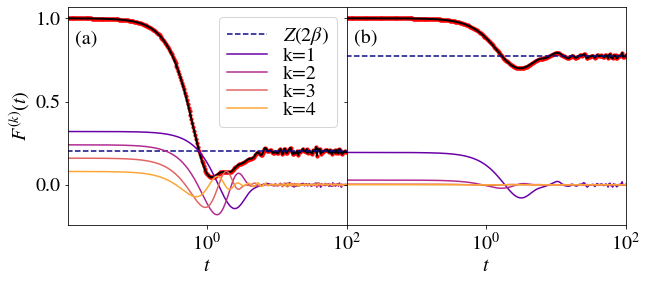

In [88]:
#fhat=np.real(F_Z/F_Z[0]) #Define Fhat=F(t)/F(0)ç
acumF_k=np.sum(F_k, axis=1)
fhat=np.real(F_Z)
fig, (ax1, ax2)=plt.subplots(1, 2, sharey=True, figsize=[10, 4])
minf=np.min(fhat)
ax1.scatter(t_arr, fhat_b0, color='red', s=10)
ax1.plot(t_arr, acumF_k_b0, lw=2, color='black')
ax2.scatter(t_arr, fhat, color='red', s=10)
ax2.plot(t_arr, acumF_k, lw=2, color='black', label=r"$\sum_k F^{(k)}(t)$")
cm = plt.get_cmap('plasma')
#ax.set_color_cycle([cm(1.*k/dim) for i in range(dim)])
lines = ax1.plot(t_arr, F_k_b0[:,0], label=r"$Z(2 \beta)$", ls='--')
lines[0].set_color(cm(0/dim))
lines = ax2.plot(t_arr, F_k[:,0], label=r"$Z(2 \beta)$", ls='--')
lines[0].set_color(cm(0/dim))
for k in range(1,dim):
    lines = ax1.plot(t_arr, F_k_b0[:,k], label="k="+str(k))
    lines[0].set_color(cm(k/dim))
    lines = ax2.plot(t_arr, F_k[:,k], label="k="+str(k))
    lines[0].set_color(cm(k/dim))
#plt.scatter(t_arr, np.real(F_t/F_t[0]), label='Numerics GUE <./.>')
#cb=fig.colorbar(lines, ax=ax)
#cb.set_label("k")
plt.subplots_adjust(wspace=0)
ax1.set_xlabel("$t$")
ax1.set_ylabel("$F^{(k)}(t)$")
ax1.set_xscale('log')
ax2.set_xscale('log')
ax2.set_xlim(t_arr[1],t_arr[-1])
ax2.set_xlabel("$t$")
#plt.yscale('log')
ax1.set_xlim(t_arr[1],t_arr[-1])
#plt.ylim(np.min(fhat), 1)
ax1.legend(labelspacing=0)
ax1.text(1.3e-2,0.85, "(a)")
ax2.text(1.3e-2,0.85, "(b)")
plt.show()

In [80]:
"""fhat_b0=fhat
acumF_k_b0=acumF_k
F_k_b0=F_k"""

'fhat_b0=fhat\nacumF_k_b0=acumF_k\nF_k_b0=F_k'